In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader
import random
import time
from tqdm.notebook import tqdm

import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC
import networkx as nx
from scipy import sparse as sp

import os
import pickle

import hashlib

from models import GraphRegressionGraphTransformer, GraphTransformerEdges, GraphTransformer, GraphRegressionGraphTransformerEdges
from preprocess import AddLaplacianPosEncoding
from train import train_one_epoch, evaluate

In [2]:
SEED = 0

if torch.cuda.is_available():
    print('cuda available with GPU:',torch.cuda.get_device_name(0))
    device = torch.device("cuda")
else:
    print('cuda not available')
    device = torch.device("cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)


cuda available with GPU: NVIDIA GeForce GTX 1660 Ti


# Parameters

In [3]:
# Dimension of positional encoding, ex number of non-trivial eigenvalues for laplacian positional encoding
POS_ENCODING_DIM = 6

# Training parameters
BATCH_SIZE = 128
INIT_LR = 0.0007
WEIGHT_DECAY = 0.0
LR_REDUCE_FACTOR = 0.5
PATIENCE = 15
MIN_LR = 1e-6
EPOCHS = 50

# Network parameters
n_hidden = 64
n_head = 8
n_feedforward = 160
n_layers = 10
input_dropout = 0.0
dropout = 0.0
norm = 'layer'
readout = 'mean'

# Data

In [4]:
# Dataset and prior transforms
data_transforms = T.Compose([
    AddLaplacianPosEncoding(POS_ENCODING_DIM),
    T.AddSelfLoops('edge_attr')
    ])


dataset_train = ZINC('data', subset=True, split='train', pre_transform=data_transforms)
dataset_val = ZINC('data', subset=True, split='val', pre_transform=data_transforms)
dataset_test = ZINC('data', subset=True, split='test', pre_transform=data_transforms)

In [5]:
# Dataloaders
dataloader_train = torch_geometric.loader.DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = torch_geometric.loader.DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = torch_geometric.loader.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# Vocabulary sizes for nodes and edges, for embedding layers
n_nodes_input = torch.unique(dataset_train.x[:,0]).size(0)
n_edges_input = torch.unique(dataset_train.edge_attr).size(0)+1

# Training and test

In [7]:
model = GraphRegressionGraphTransformerEdges(n_nodes_input, 
                                             n_edges_input, 
                                             n_hidden, 
                                             n_head, 
                                             n_feedforward, 
                                             n_layers, 
                                             input_dropout=input_dropout, 
                                             dropout=dropout, 
                                             k=POS_ENCODING_DIM, 
                                             norm=norm,
                                             readout = readout)
model = model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=INIT_LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=LR_REDUCE_FACTOR,
                                                 patience=PATIENCE,
                                                 verbose=True)

epoch_train_losses, epoch_val_losses = [], []
epoch_train_accs, epoch_val_accs = [], [] 

In [8]:
for epoch in range(EPOCHS):
    
    epoch_train_loss, optimizer = train_one_epoch(model, dataloader_train, epoch, device, optimizer, criterion)

    epoch_val_loss = evaluate(model, dataloader_val, device, criterion) 

    epoch_train_losses.append(epoch_train_loss)
    epoch_val_losses.append(epoch_val_loss)

    lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{EPOCHS}: Train loss = {epoch_train_loss:.4f}, Validation loss = {epoch_val_loss:.4f}, Learning rate = {lr}')

Epoch 1/50: Train loss = 1.1252, Validation loss = 0.8926, Learning rate = 0.0007


  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
epoch_test_loss = evaluate(model, dataloader_test, device, criterion)
epoch_test_loss

  0%|          | 0/8 [00:00<?, ?it/s]

0.648884691298008

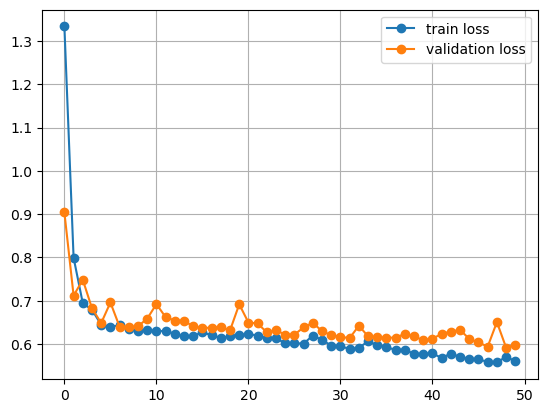

In [19]:
plt.plot(range(EPOCHS), epoch_train_losses, '-o', label='train loss')
plt.plot(range(EPOCHS), epoch_val_losses, '-o', label='validation loss')
plt.legend()
plt.grid()

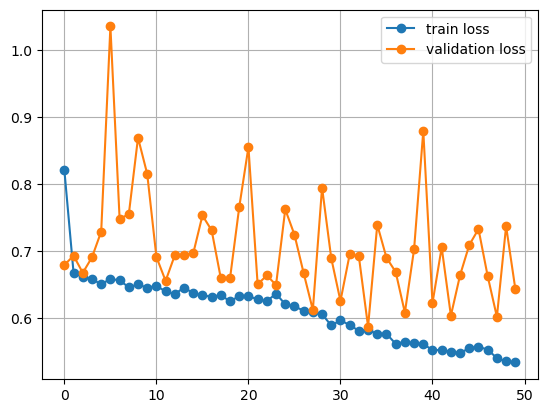

In [12]:
plt.plot(range(EPOCHS), epoch_train_losses, '-o', label='train loss')
plt.plot(range(EPOCHS), epoch_val_losses, '-o', label='validation loss')
plt.legend()
plt.grid()

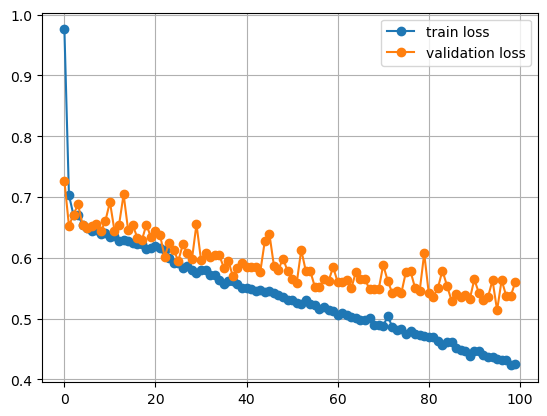

In [42]:
plt.plot(range(EPOCHS), epoch_train_losses, '-o', label='train loss')
plt.plot(range(EPOCHS), epoch_val_losses, '-o', label='validation loss')
plt.legend()
plt.grid()

In [48]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

463745